In [1]:
from rl_qoc.qua import QMEnvironment, QMConfig, QMBackend, CustomQMPPO
from rl_qoc.qua.qm_backend import FluxTunableTransmonBackend
from rl_qoc.qua.quam_components import QuAM
from qm.qua import *
from qm_saas import QmSaas, QoPVersion
from rl_qoc.qua.parameter_table import ParameterTable, Parameter as QuaParameter
from qm import QuantumMachinesManager, SimulationConfig
import numpy as np
import matplotlib.pyplot as plt

machine = QuAM.load(
    f"/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/pulse_level/qua/quam_state"
)

2025-02-27 09:54:51,969 - qm - INFO     - Starting session: a9f6448e-8259-402c-ada4-eebfcfdad340
2025-02-27 09:54:51 INFO Starting session: a9f6448e-8259-402c-ada4-eebfcfdad340


/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/quam/core/quam_classes.py:497: UserWarning: No QuamRoot initialized, cannot retrieve reference #/wiring/qubit_pairs/q1-2/c/opx_output from TunableCoupler
  warnings.warn(
/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/quam/core/quam_classes.py:497: UserWarning: No QuamRoot initialized, cannot retrieve reference #/wiring/qubit_pairs/q2-3/c/opx_output from TunableCoupler
  warnings.warn(
/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/quam/core/quam_classes.py:497: UserWarning: No QuamRoot initialized, cannot retrieve reference #/wiring/qubit_pairs/q3-4/c/opx_output from TunableCoupler
  warnings.warn(
/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/quam/core/quam_classes.py:497: UserWarning: No QuamRoot initialized, cannot retrieve reference #/wiring/qubit_pairs/q4-5/c/opx_output from TunableCoupler
  warnings.warn(


In [2]:
from typing import Union, Any
from quam.components.macro import QubitMacro, QubitPairMacro, PulseMacro
from quam.components.pulses import ReadoutPulse

q1 = machine.active_qubits[0]


class MeasureMacro(PulseMacro):
    pulse: Union[ReadoutPulse, str] = "readout"

    def apply(self, *args, **kwargs) -> Any:
        state = declare(int)
        I, Q = declare(fixed), declare(fixed)
        if isinstance(self.pulse, str):
            pulse = self.qubit.get_pulse(self.pulse)
        else:
            pulse = self.pulse
        assert isinstance(pulse, ReadoutPulse), "MeasureMacro can only be used with ReadoutPulse"
        self.qubit.resonator.measure(pulse.name, qua_vars=(I, Q))
        assign(state, Cast.to_int(I > pulse.threshold))
        return state


q1.macros["x"] = PulseMacro(pulse="x180_DragCosine")
q1.macros["rz"] = PulseMacro(pulse="rz")
q1.macros["sx"] = PulseMacro(pulse="sx")
q1.macros["measure"] = MeasureMacro(pulse="readout")

In [4]:
q1.get_macros()

{'x': PulseMacro(id='x', pulse='x180_DragCosine'),
 'rz': PulseMacro(id='rz', pulse='rz'),
 'sx': PulseMacro(id='sx', pulse='sx'),
 'measure': MeasureMacro(id='measure', pulse='readout')}

In [5]:
q2 = machine.active_qubits[1]
q2.macros["x"] = PulseMacro(pulse="x")

In [6]:
backend = QMBackend(machine)
print(backend.target)

Target: Transmon based QuAM
Number of qubits: 5
Instructions:
	x
		(0,)
		(1,)
	rz
		(0,)
	sx
		(0,)
	measure
		(0,)
	switch_case
	for_loop
	if_else
	while_loop



In [7]:
pair = machine.active_qubit_pairs[0]
pair.macros["cz"] = PulseMacro(pulse="cz")

In [8]:
from rl_qoc import QEnvConfig, ExecutionConfig, PPOConfig, QuantumEnvironment
from qiskit.circuit.library import CZGate
from gymnasium.spaces import Box

seed = 30499
action_space = Box(low=-1, high=1, shape=(4,), dtype=np.float32)
observation_space = Box(low=-1, high=1, shape=(1,), dtype=np.float32)
batch_size = 30


def apply_circuit(qc, params, qreg):
    qc.append(CZGate("cz_cal"), [qreg[0], qreg[1]])


env_config = QEnvConfig(
    target={"gate": "cz", "physical_qubits": [0, 1]},
    backend_config=QMConfig(backend=backend, parametrized_circuit=apply_circuit, qubit_pair=pair),
    action_space=action_space,
    execution_config=ExecutionConfig(batch_size=batch_size, seed=seed),
)
ppo_config = PPOConfig()
env = QuantumEnvironment(env_config)
agent = CustomQMPPO(ppo_config, env)

In [9]:
# These should be changed to your credentials.
from pathlib import Path
import json

path = Path.home() / "qm_saas_config.json"
with open(path, "r") as f:
    config = json.load(f)
email = config["email"]
password = config["password"]
#

# Initialize QOP simulator client
client = QmSaas(email=email, password=password, host="qm-saas.dev.quantum-machines.co")

# Choose your QOP version (QOP2.x.y or QOP3.x.y)
version = QoPVersion.v3_2_0
n_actions = 4
µ = QuaParameter("µ", 0.5 * np.ones(n_actions))
σ = QuaParameter("σ", 0.2 * np.ones(n_actions))
action = QuaParameter("action", np.zeros(n_actions))
client.close_all()

In [10]:
def get_gaussian_sampling_input():
    """
    Get the input for the gaussian sampling function
    """
    n_lookup = 512

    cos_array = declare(
        fixed,
        value=[(np.cos(2 * np.pi * x / n_lookup).tolist()) for x in range(n_lookup)],
    )
    ln_array = declare(
        fixed,
        value=[(np.sqrt(-2 * np.log(x / (n_lookup + 1))).tolist()) for x in range(1, n_lookup + 1)],
    )
    return (
        n_lookup,
        cos_array,
        ln_array,
    )


with program() as prog:
    µ.declare_variable()
    σ.declare_variable()
    action.declare_variable()
    n_lookup, cos_array, ln_array = get_gaussian_sampling_input()
    uniform_r = declare(fixed)
    u1, u2 = declare(int), declare(int)
    temp1 = declare(fixed, size=n_actions)
    temp2 = declare(fixed, size=n_actions)
    gaussian_samples = declare(fixed, size=batch_size)

    i = declare(int)
    j = declare(int)

    rng = Random(seed=seed)
    q1.apply("x")
    with for_(i, 0, i < batch_size, i + 2):
        with for_(j, 0, j < n_actions, j + 1):
            assign(uniform_r, rng.rand_fixed())
            assign(u1, Cast.unsafe_cast_int(uniform_r >> 19))
            assign(u2, Cast.unsafe_cast_int(uniform_r) & ((1 << 19) - 1))
            assign(
                temp1[j],
                µ.var[j] + σ.var[j] * ln_array[u1] * cos_array[u2 & (n_lookup - 1)],
            )
            assign(
                temp2[j],
                µ.var[j]
                + σ.var[j] * ln_array[u1] * cos_array[(u2 + n_lookup // 4) & (n_lookup - 1)],
            )
        action.assign_value(temp1, is_qua_array=True)
        action.save_to_stream()
        action.assign_value(temp2, is_qua_array=True)
        action.save_to_stream()

    with stream_processing():
        action.stream.buffer(n_actions).save_all("action")

In [11]:
client.close_all()
config = machine.generate_config()
instance = client.simulator(version=version)
instance.spawn()
instance.port

9510

In [12]:
# Initialize QuantumMachinesManager with the simulation instance details
qmm = QuantumMachinesManager(
    host=instance.host,
    port=instance.port,
    connection_headers=instance.default_connection_headers,
)
qm = qmm.open_qm(config)
job = qm.simulate(prog, SimulationConfig(int(7000), include_analog_waveforms=True))

# Retrieve and handle simulated samples
samples = job.get_simulated_samples()
results = job.result_handles
results.wait_for_all_values()
results

2025-02-27 10:02:33,993 - qm - INFO     - Performing health check
2025-02-27 10:02:33 INFO Performing health check
2025-02-27 10:02:34,562 - qm - INFO     - Cluster healthcheck completed successfully.
2025-02-27 10:02:34 INFO Cluster healthcheck completed successfully.
2025-02-27 10:02:36,869 - qm - INFO     - Simulating program.
2025-02-27 10:02:36 INFO Simulating program.


In [11]:
gaussian1 = results.get("action").fetch_all()["value"]
print(gaussian1)
print(gaussian1.shape)

[[ 0.70522086  0.47219296  0.3529095   0.24953547]
 [ 0.29477914  0.82290639  0.55673906  0.74439143]
 [ 0.27211449  0.69636537  0.62637319  0.41802219]
 [ 0.11979599  0.52666961  0.04334597  0.52820222]
 [ 0.72584636  0.53272336  0.54373862  0.31768437]
 [ 0.62071739  0.47754925  0.14537664  0.27220382]
 [ 0.5407134   0.72455617  0.13345355  0.71792946]
 [ 0.53690047  0.36163254  0.88499577  0.44824514]
 [ 0.56393336  0.99719543  0.47100865  0.40171652]
 [ 0.1785853   0.644184    0.47958199  0.56394042]
 [ 0.60527904  0.36872343  0.19893287  0.70911494]
 [ 0.54979328  0.88159287  0.59945914  0.47159879]
 [ 0.62438472  0.43135129  0.63779448  0.35397688]
 [ 0.48774917  0.33985468  0.43064008  0.21855589]
 [ 0.06936614  0.52291466  0.96956132  0.29554184]
 [ 0.4361215   0.56164654  0.58147662  0.50753064]
 [ 0.45854196  0.54553116  0.50839052  0.17411733]
 [ 0.39991145  0.41224349  0.15820798  0.63032315]
 [ 0.15282351  0.21368806  0.54775607  0.46039025]
 [ 0.55149877  0.33313243  0.53

(array([[0., 0., 0., 0., 1., 2., 1., 2., 4., 2., 2., 2., 7., 3., 1., 3.,
         0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 3., 4., 2., 4., 5., 1., 3., 1.,
         0., 2., 1., 1.],
        [0., 0., 0., 1., 0., 3., 1., 0., 1., 2., 3., 4., 6., 5., 1., 0.,
         0., 0., 2., 1.],
        [0., 0., 0., 0., 0., 0., 3., 2., 4., 2., 4., 5., 5., 1., 0., 3.,
         1., 0., 0., 0.]]),
 array([-0.19123648, -0.13181489, -0.07239329, -0.01297169,  0.0464499 ,
         0.1058715 ,  0.16529309,  0.22471469,  0.28413628,  0.34355788,
         0.40297947,  0.46240107,  0.52182267,  0.58124426,  0.64066586,
         0.70008745,  0.75950905,  0.81893064,  0.87835224,  0.93777383,
         0.99719543]),
 <a list of 4 BarContainer objects>)

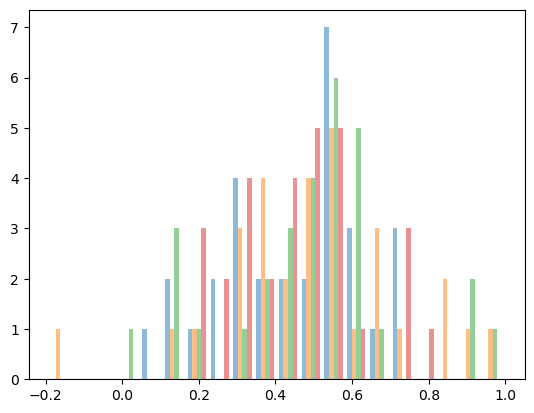

In [12]:
plt.hist(gaussian1, bins=20, alpha=0.5, label="gaussian1")

In [13]:
from torch.distributions import Normal
from torch import tensor

dist = Normal(tensor(0.5 * np.ones((batch_size, 4))), tensor(0.2 * np.ones((batch_size, 4))))
action, log_prob = agent.process_action(dist)
action = action.numpy()
print(action)

[[ 0.70522086  0.47219296  0.35290951  0.24953547]
 [ 0.29477914  0.82290639  0.55673906  0.74439143]
 [ 0.27211449  0.69636537  0.62637319  0.41802219]
 [ 0.11979599  0.52666961  0.04334597  0.52820222]
 [ 0.72584635  0.53272335  0.54373862  0.31768437]
 [ 0.62071739  0.47754925  0.14537664  0.27220383]
 [ 0.5407134   0.72455617  0.13345355  0.71792946]
 [ 0.53690047  0.36163255  0.88499577  0.44824514]
 [ 0.56393335  0.99719543  0.47100865  0.40171652]
 [ 0.1785853   0.644184    0.47958199  0.56394042]
 [ 0.60527904  0.36872343  0.19893287  0.70911493]
 [ 0.54979328  0.88159287  0.59945914  0.47159879]
 [ 0.62438472  0.43135129  0.63779448  0.35397688]
 [ 0.48774917  0.33985468  0.43064008  0.21855589]
 [ 0.06936614  0.52291466  0.96956132  0.29554184]
 [ 0.4361215   0.56164654  0.58147661  0.50753064]
 [ 0.45854196  0.54553116  0.50839052  0.17411733]
 [ 0.39991145  0.4122435   0.15820798  0.63032315]
 [ 0.15282351  0.21368806  0.54775607  0.46039025]
 [ 0.55149876  0.33313243  0.53

/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/qua/qua_ppo.py:39: RuntimeWarning: overflow encountered in scalar multiply
  return (a * seed + c) % m


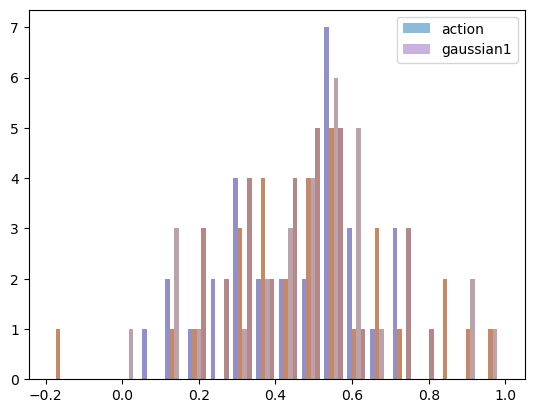

In [14]:
plt.hist(action, bins=20, alpha=0.5, label="action")
plt.hist(gaussian1, bins=20, alpha=0.5, label="gaussian1")
plt.legend(loc="upper right")

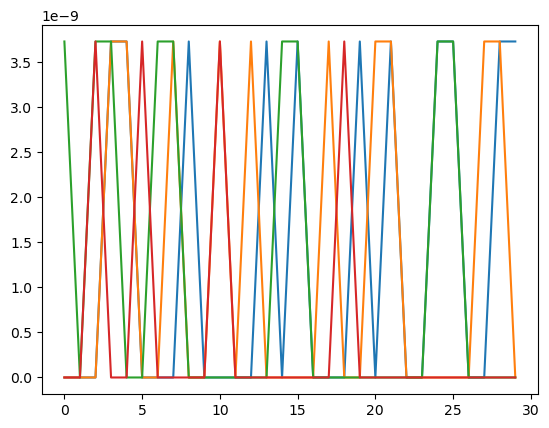

In [15]:
plt.plot(np.abs(action - gaussian1))

In [16]:
print(action.shape)

(30, 4)


In [17]:
print(gaussian1.shape)

(30, 4)


In [18]:
print(np.mean(np.abs(action - gaussian1)))

1.0554989178975423e-09
